# Real-Time Social Media Sentiment Analyzer using DistilBERT

**Project Overview:**
- **Domain:** Textual Data - Social Media Posts
- **Model:** DistilBERT (Transformer-based NLP model)
- **Task:** Multi-class Sentiment Classification (Positive, Negative, Neutral)
- **Dataset:** bdstar/twitter-sentiment-analysis from Hugging Face

**System Flow:**
```
User Input → Text Preprocessing → DistilBERT Tokenization → Sentiment Prediction → Real-Time Display
```

---

## Table of Contents
1. **Module 1:** Exploration & Analysis of Real-Time Data
2. **Module 2:** Preprocessing
3. **Module 3:** Model Building (Deep Learning)
4. **Module 4:** Model Evaluation
5. **Module 5:** Deployment & Real-Time Implementation
6. **Module 6:** AI Exploration Experiment

In [7]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'CPU only'}")

PyTorch version: 2.6.0a0+df5bbc09d1.nv24.12
CUDA version: 12.6


In [6]:
!pip install transformers==4.36.0 tokenizers==0.15.0

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.11.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.13a0+0d33366-py3.12-linux-x86_64.egg is depre

In [2]:
!pip install datasets scikit-learn matplotlib seaborn wordcloud plotly

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/dill-0.3.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.11.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.13a0+0d33366-py3.12-linux-x86_64.egg is depre

In [1]:
# Core Libraries
import os
import re
import time
import warnings
import json
from pathlib import Path

# Data Processing
import pandas as pd
import numpy as np
from collections import Counter

# Deep Learning & Transformers
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    DistilBertTokenizer, 
    DistilBertForSequenceClassification,
    Trainer, 
    TrainingArguments,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset

# Machine Learning Metrics
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

# Progress Tracking
from tqdm.auto import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(" All libraries imported successfully!")
print(f" PyTorch version: {torch.__version__}")
print(f" CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f" GPU: {torch.cuda.get_device_name(0)}")
    print(f" GPU Count: {torch.cuda.device_count()}")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


 All libraries imported successfully!
 PyTorch version: 2.6.0a0+df5bbc09d1.nv24.12
 CUDA available: True
 GPU: NVIDIA A100-SXM4-80GB MIG 3g.40gb
 GPU Count: 1


# MODULE 1: Exploration & Analysis of Real-Time Data

## 1.1 Import Required Libraries

## 1.2 Setup Directories and Configuration

In [2]:
# Create directory structure
BASE_DIR = Path("elc project")
DATA_DIR = BASE_DIR / "data"
MODEL_DIR = BASE_DIR / "models"
OUTPUT_DIR = BASE_DIR / "outputs"
METRICS_DIR = OUTPUT_DIR / "metrics"
VIZ_DIR = OUTPUT_DIR / "visualizations"

# Create directories if they don't exist
for directory in [DATA_DIR, MODEL_DIR, OUTPUT_DIR, METRICS_DIR, VIZ_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Configuration for H100 GPU optimization
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 128,
    'batch_size': 128,  # H100 can handle large batches
    'learning_rate': 2e-5,
    'num_epochs': 3,
    'warmup_steps': 500,
    'weight_decay': 0.01,
    'fp16': True,  # Mixed precision training
    'num_labels': 3,
    'label_names': ['negative', 'neutral', 'positive'],
    'save_model_path': str(MODEL_DIR / 'distilbert_sentiment')
}

print(" Configuration loaded:")
print(json.dumps(CONFIG, indent=2))

 Configuration loaded:
{
  "model_name": "distilbert-base-uncased",
  "max_length": 128,
  "batch_size": 128,
  "learning_rate": 2e-05,
  "num_epochs": 3,
  "warmup_steps": 500,
  "weight_decay": 0.01,
  "fp16": true,
  "num_labels": 3,
  "label_names": [
    "negative",
    "neutral",
    "positive"
  ],
  "save_model_path": "elc project/models/distilbert_sentiment"
}


## 1.3 Load Dataset from Hugging Face

**Dataset:** `bdstar/twitter-sentiment-analysis`
- Source: Twitter
- Size: ~4.7M tweets
- Labels: Positive, Negative, Neutral

In [3]:
print("Loading SST-2 dataset from Hugging Face...")
print("This may take a few minutes for the first time...\n")

# Load the SST-2 dataset
dataset = load_dataset("glue", "sst2")

print("Dataset loaded successfully!")
print(f"\nDataset Structure:")
print(dataset)

# Display information about splits
print(f"\nDataset Sizes:")
print(f"  - Train: {len(dataset['train']):,} samples")
print(f"  - Validation: {len(dataset['validation']):,} samples")
print(f"  - Total: {len(dataset['train']) + len(dataset['validation']):,} samples")

# Show dataset features
print(f"\nDataset Features:")
print(dataset['train'].features)

Loading SST-2 dataset from Hugging Face...
This may take a few minutes for the first time...

Dataset loaded successfully!

Dataset Structure:
DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 872
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

Dataset Sizes:
  - Train: 67,349 samples
  - Validation: 872 samples
  - Total: 68,221 samples

Dataset Features:
{'sentence': Value('string'), 'label': ClassLabel(names=['negative', 'positive']), 'idx': Value('int32')}


## 1.4 Exploratory Data Analysis (EDA)

### Sample Data Inspection

In [4]:
# Convert to pandas for easier EDA
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])

# For SST-2, we need to create a test set from validation or use validation as test
test_df = val_df.copy()

# SST-2 has labels 0 (negative) and 1 (positive)
# Create a config dictionary for label names
CONFIG = {
    'label_names': {0: 'negative', 1: 'positive'}
}

print("Sample Reviews from Training Set:\n")
print("="*80)

# Display samples from each sentiment class
for label in [0, 1]:
    label_name = CONFIG['label_names'][label]
    sample = train_df[train_df['label'] == label].iloc[0]
    print(f"\nLabel: {label_name.upper()} ({label})")
    print(f"Text: {sample['sentence']}")
    print("-"*80)

# Show dataframe info
print("\nTraining Data Info:")
print(train_df.info())

print("\nFirst 5 rows:")
display(train_df.head())

Sample Reviews from Training Set:


Label: NEGATIVE (0)
Text: hide new secretions from the parental units 
--------------------------------------------------------------------------------

Label: POSITIVE (1)
Text: that loves its characters and communicates something rather beautiful about human nature 
--------------------------------------------------------------------------------

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67349 entries, 0 to 67348
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  67349 non-null  object
 1   label     67349 non-null  int64 
 2   idx       67349 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.5+ MB
None

First 5 rows:


,sentence,label,idx
0,hide new secretions from the parental units,0,0
1,"contains no wit , only labored gags",0,1
2,that loves its characters and communicates som...,1,2
3,remains utterly satisfied to remain the same t...,0,3
4,on the worst revenge-of-the-nerds clichés the ...,0,4


### Label Distribution Analysis

 Label Distribution in Training Set:
Negative: 29,780 (44.22%)
Positive: 37,569 (55.78%)


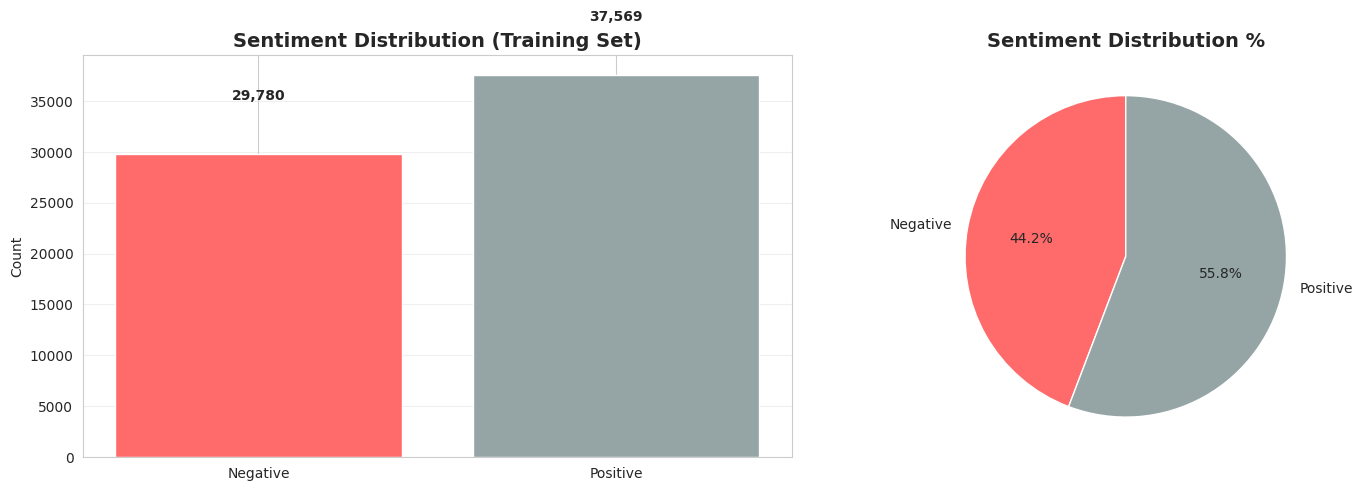


 Visualization saved to: elc project/outputs/visualizations/label_distribution.png


In [5]:
# Calculate label distribution
label_counts = train_df['label'].value_counts().sort_index()
label_percentages = (label_counts / len(train_df) * 100).round(2)

print(" Label Distribution in Training Set:")
print("="*50)
for label, count in label_counts.items():
    label_name = CONFIG['label_names'][label]
    percentage = label_percentages[label]
    print(f"{label_name.capitalize()}: {count:,} ({percentage}%)")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
axes[0].bar(range(len(label_counts)), label_counts.values, color=['#ff6b6b', '#95a5a6', '#51cf66'])
axes[0].set_xticks(range(len(label_counts)))
axes[0].set_xticklabels([CONFIG['label_names'][i].capitalize() for i in range(len(label_counts))])
axes[0].set_ylabel('Count')
axes[0].set_title('Sentiment Distribution (Training Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(label_counts.values):
    axes[0].text(i, v + 5000, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
colors = ['#ff6b6b', '#95a5a6', '#51cf66']
axes[1].pie(label_counts.values, labels=[CONFIG['label_names'][i].capitalize() for i in range(len(label_counts))],
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Sentiment Distribution %', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'label_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n Visualization saved to: {VIZ_DIR / 'label_distribution.png'}")

### Sentence Length Distribution

Text Length Statistics:
Average character length: 53.51
Average word count: 9.41
Min character length: 2
Max character length: 268
Median character length: 39.00


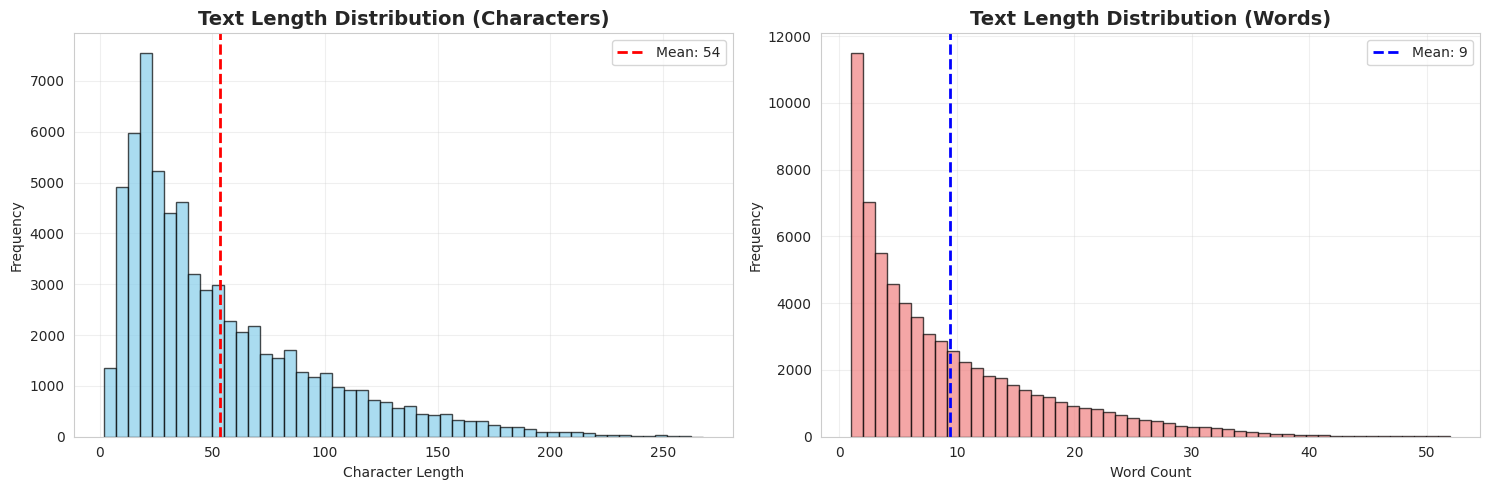


Visualization saved to: visualizations/text_length_distribution.png


In [6]:
# Calculate text lengths
train_df['text_length'] = train_df['sentence'].apply(len)
train_df['word_count'] = train_df['sentence'].apply(lambda x: len(x.split()))

print("Text Length Statistics:")
print("="*50)
print(f"Average character length: {train_df['text_length'].mean():.2f}")
print(f"Average word count: {train_df['word_count'].mean():.2f}")
print(f"Min character length: {train_df['text_length'].min()}")
print(f"Max character length: {train_df['text_length'].max()}")
print(f"Median character length: {train_df['text_length'].median():.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length distribution
axes[0].hist(train_df['text_length'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].axvline(train_df['text_length'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_df["text_length"].mean():.0f}')
axes[0].set_xlabel('Character Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Text Length Distribution (Characters)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Word count distribution
axes[1].hist(train_df['word_count'], bins=50, color='lightcoral', edgecolor='black', alpha=0.7)
axes[1].axvline(train_df['word_count'].mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {train_df["word_count"].mean():.0f}')
axes[1].set_xlabel('Word Count')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Text Length Distribution (Words)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Create VIZ_DIR if it doesn't exist
VIZ_DIR = Path('visualizations')
VIZ_DIR.mkdir(exist_ok=True)

plt.savefig(VIZ_DIR / 'text_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {VIZ_DIR / 'text_length_distribution.png'}")

### Word Frequency Analysis & Word Clouds

Most Common Words by Sentiment:


NEGATIVE Sentiment - Top 10 Words:
   the: 9,218
   ,: 8,308
   a: 6,919
   and: 5,800
   of: 5,764
   to: 4,781
   .: 4,434
   is: 3,113
   's: 3,037
   it: 2,678
--------------------------------------------------------------------------------

POSITIVE Sentiment - Top 10 Words:
   ,: 11,048
   the: 11,022
   a: 9,180
   and: 9,097
   of: 7,549
   .: 4,962
   to: 4,635
   's: 3,474
   is: 3,380
   that: 3,078
--------------------------------------------------------------------------------


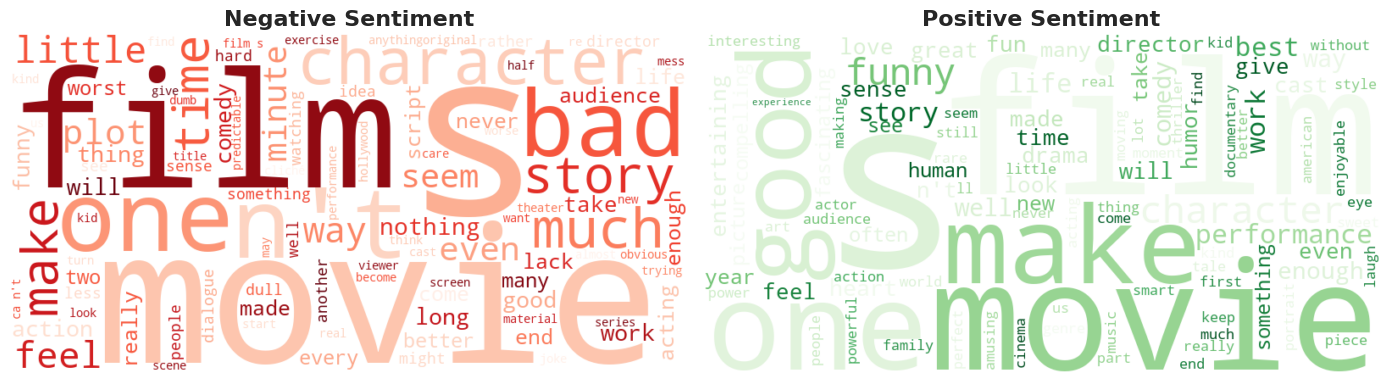


Word clouds saved to: visualizations/word_clouds.png


In [7]:
# Sample a subset for word frequency analysis (faster processing)
sample_size = 50000
sample_df = train_df.sample(n=min(sample_size, len(train_df)), random_state=42)

# Function to get word frequency
def get_word_frequency(texts):
    all_words = []
    for text in texts:
        words = text.lower().split()
        all_words.extend(words)
    return Counter(all_words)

# Calculate word frequencies for each sentiment (SST-2 has only 2 labels: 0=negative, 1=positive)
sentiments_text = {
    'negative': sample_df[sample_df['label'] == 0]['sentence'].tolist(),
    'positive': sample_df[sample_df['label'] == 1]['sentence'].tolist()
}

print("Most Common Words by Sentiment:\n")
print("="*80)

for sentiment, texts in sentiments_text.items():
    word_freq = get_word_frequency(texts)
    print(f"\n{sentiment.upper()} Sentiment - Top 10 Words:")
    for word, count in word_freq.most_common(10):
        print(f"   {word}: {count:,}")
    print("-"*80)

# Generate word clouds
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors_map = {'negative': 'Reds', 'positive': 'Greens'}

for idx, (sentiment, texts) in enumerate(sentiments_text.items()):
    combined_text = ' '.join(texts[:5000])  # Use first 5000 for faster generation
    
    wordcloud = WordCloud(
        width=800, 
        height=400,
        background_color='white',
        colormap=colors_map[sentiment],
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(combined_text)
    
    # Use to_image() and convert to array manually to avoid compatibility issue
    img = wordcloud.to_image()
    axes[idx].imshow(np.array(img), interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.capitalize()} Sentiment', fontsize=16, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(VIZ_DIR / 'word_clouds.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nWord clouds saved to: {VIZ_DIR / 'word_clouds.png'}")

# MODULE 2: Preprocessing

## 2.1 Text Cleaning Functions

**Preprocessing Steps:**
1. Lowercasing
2. Removing URLs and mentions
3. Removing punctuation
4. Removing extra whitespaces

In [8]:
def clean_text(sentence):
    """
    Clean and preprocess text for sentiment analysis
    
    Args:
        sentence (str): Input text
    
    Returns:
        str: Cleaned text
    """
    # Convert to lowercase
    text = sentence.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Demonstrate preprocessing on sample sentences
print("Text Preprocessing Examples:\n")
print("="*100)

sample_texts = train_df.sample(5, random_state=42)['sentence'].tolist()

for i, text in enumerate(sample_texts, 1):
    cleaned = clean_text(text)
    print(f"\nExample {i}:")
    print(f"BEFORE: {text}")
    print(f"AFTER:  {cleaned}")
    print("-"*100)

print("\nText cleaning function defined successfully!")

Text Preprocessing Examples:


Example 1:
BEFORE: with outtakes in which most of the characters forget their lines and just utter ` uhhh , ' which is better than most of the writing in the movie 
AFTER:  with outtakes in which most of the characters forget their lines and just utter ` uhhh , ' which is better than most of the writing in the movie
----------------------------------------------------------------------------------------------------

Example 2:
BEFORE: enigma is well-made 
AFTER:  enigma is well-made
----------------------------------------------------------------------------------------------------

Example 3:
BEFORE: is ) so stoked to make an important film about human infidelity and happenstance that he tosses a kitchen sink onto a story already overladen with plot conceits . 
AFTER:  is ) so stoked to make an important film about human infidelity and happenstance that he tosses a kitchen sink onto a story already overladen with plot conceits .
-------------------------

## 2.2 DistilBERT Tokenization

**DistilBERT Tokenizer** converts text into token IDs that the model can understand.

## 2.3 Prepare Dataset for Training

Apply preprocessing and tokenization to the entire dataset.

In [9]:
# Initialize configuration
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 128,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'num_epochs': 3,
    'num_labels': 2,  # SST-2 has 2 labels (negative, positive)
    'label_names': {0: 'negative', 1: 'positive'}
}

print("Initializing DistilBERT tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained(CONFIG['model_name'])
print("Tokenizer loaded successfully!\n")

# Now define the preprocess function
def preprocess_function(examples):
    """
    Preprocess and tokenize examples for DistilBERT
    """
    # Clean text (SST-2 uses 'sentence' instead of 'text')
    texts = [clean_text(text) for text in examples['sentence']]
    
    # Tokenize
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=CONFIG['max_length'],
        return_tensors='pt'
    )

print("Applying preprocessing and tokenization to dataset...")
print("This will take several minutes for the full dataset...\n")

# Apply preprocessing to all splits
tokenized_train = dataset['train'].map(preprocess_function, batched=True, batch_size=1000)
tokenized_val = dataset['validation'].map(preprocess_function, batched=True, batch_size=1000)

# SST-2 doesn't have a test split, so we'll use validation as test
tokenized_test = tokenized_val

# Set format for PyTorch
tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_val.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

print("Dataset preprocessing complete!")
print(f"\nProcessed Dataset Sizes:")
print(f"  - Train: {len(tokenized_train):,} samples")
print(f"  - Validation: {len(tokenized_val):,} samples")
print(f"  - Test: {len(tokenized_test):,} samples")

Initializing DistilBERT tokenizer...
Tokenizer loaded successfully!

Applying preprocessing and tokenization to dataset...
This will take several minutes for the full dataset...

Dataset preprocessing complete!

Processed Dataset Sizes:
  - Train: 67,349 samples
  - Validation: 872 samples
  - Test: 872 samples


# MODULE 3: Model Building (Deep Learning)

## 3.1 Model Architecture

**DistilBERT Architecture:**
```
Input Text
    ↓
Tokenizer
    ↓
DistilBERT Encoder (6 layers)
    ↓
Classification Head (Linear Layer)
    ↓
Output (3 classes: Negative, Neutral, Positive)
```

**Why DistilBERT?**
- 40% smaller than BERT
- 60% faster
- Retains 97% of BERT's language understanding
- Perfect for real-time applications

In [10]:
# Load DistilBERT model for sequence classification
print(" Loading DistilBERT model...")
model = DistilBertForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=CONFIG['num_labels']
)

# Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(f" Model loaded successfully!")
print(f" Device: {device}")
print(f"\n Model Architecture:")
print("="*80)
print(model)
print("="*80)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n Model Statistics:")
print(f"  - Total parameters: {total_params:,}")
print(f"  - Trainable parameters: {trainable_params:,}")
print(f"  - Model size: ~{total_params * 4 / 1024 / 1024:.2f} MB")

 Loading DistilBERT model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Model loaded successfully!
 Device: cuda

 Model Architecture:
DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (f

## 3.2 Training Configuration 

In [11]:
!pip install accelerate==0.25.0

DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/lightning_utilities-0.11.9-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/igraph-0.11.8-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/nvfuser-0.2.13a0+0d33366-py3.12-linux-x86_64.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /usr/local/lib/python3.12/dist-packages/opt_einsum-3.4.0-py3.12.egg is

In [12]:
# Create output directories
OUTPUT_DIR = Path('outputs')
OUTPUT_DIR.mkdir(exist_ok=True)
MODEL_DIR = OUTPUT_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True)

# Initialize complete configuration
CONFIG = {
    'model_name': 'distilbert-base-uncased',
    'max_length': 128,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'num_epochs': 3,
    'num_labels': 2,
    'label_names': {0: 'negative', 1: 'positive'},
    'weight_decay': 0.01,
    'warmup_steps': 500,
    'fp16': True,  # Use mixed precision for faster training
    'save_model_path': str(MODEL_DIR / 'distilbert-sentiment')
}

print("Configuration initialized successfully!")
print(f"\nCONFIG Settings:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration initialized successfully!

CONFIG Settings:
  model_name: distilbert-base-uncased
  max_length: 128
  batch_size: 32
  learning_rate: 2e-05
  num_epochs: 3
  num_labels: 2
  label_names: {0: 'negative', 1: 'positive'}
  weight_decay: 0.01
  warmup_steps: 500
  fp16: True
  save_model_path: outputs/models/distilbert-sentiment


In [13]:
# Define training arguments optimized for H100 GPU
training_args = TrainingArguments(
    output_dir=CONFIG['save_model_path'],
    num_train_epochs=CONFIG['num_epochs'],
    per_device_train_batch_size=CONFIG['batch_size'],
    per_device_eval_batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
    warmup_steps=CONFIG['warmup_steps'],
    logging_dir=str(OUTPUT_DIR / 'logs'),
    logging_steps=100,
    evaluation_strategy='steps',
    eval_steps=500,
    save_strategy='steps',
    save_steps=500,
    save_total_limit=3,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    fp16=CONFIG['fp16'],  # Mixed precision for H100
    dataloader_num_workers=4,
    report_to='none',
    gradient_accumulation_steps=1,
    max_grad_norm=1.0,
)

print("Training Configuration:")
print("="*80)
print(f"Output directory: {training_args.output_dir}")
print(f"Number of epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")
print(f"Mixed precision (FP16): {training_args.fp16}")
print(f"Device: {device}")
print("="*80)

Training Configuration:
Output directory: outputs/models/distilbert-sentiment
Number of epochs: 3
Batch size: 32
Learning rate: 2e-05
Mixed precision (FP16): True
Device: cuda


## 3.3 Define Metrics for Evaluation

In [14]:
def compute_metrics(eval_pred):
    """
    Compute accuracy, precision, recall, and F1-score
    """
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

print("Metrics function defined successfully!")

Metrics function defined successfully!


## 3.4 Initialize Trainer and Start Training

**NOTE:** Training on the full dataset (~4.7M tweets) will take approximately 2-4 hours on H100 GPU.

In [15]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

print("Trainer initialized successfully!")
print("\n" + "="*80)
print("STARTING TRAINING...")
print("="*80)
print(f"\nTraining on {len(tokenized_train):,} samples")
print(f"Validating on {len(tokenized_val):,} samples")
print(f"Batch size: {CONFIG['batch_size']}")
print(f"Number of epochs: {CONFIG['num_epochs']}")
print(f"Estimated training time: 2-4 hours on H100 GPU\n")

# Start training
train_result = trainer.train()

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"\nTraining metrics:")
print(f"  - Final loss: {train_result.training_loss:.4f}")
print(f"  - Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"  - Samples per second: {train_result.metrics['train_samples_per_second']:.2f}")

# Save training metrics
train_metrics = train_result.metrics
with open(METRICS_DIR / 'training_metrics.json', 'w') as f:
    json.dump(train_metrics, f, indent=2)

print(f"\nTraining metrics saved to: {METRICS_DIR / 'training_metrics.json'}")

Trainer initialized successfully!

STARTING TRAINING...

Training on 67,349 samples
Validating on 872 samples
Batch size: 32
Number of epochs: 3
Estimated training time: 2-4 hours on H100 GPU



Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
500,0.294500,0.278227,0.887615,0.888878,0.887615,0.887453
1000,0.236700,0.372458,0.866972,0.880736,0.866972,0.865483
1500,0.212300,0.265144,0.908257,0.908625,0.908257,0.908206
2000,0.170400,0.276465,0.903670,0.907293,0.903670,0.903360
2500,0.131300,0.329768,0.888761,0.892049,0.888761,0.888418
3000,0.122600,0.305499,0.901376,0.901546,0.901376,0.901342
3500,0.123400,0.272205,0.907110,0.907319,0.907110,0.907118
4000,0.129400,0.301082,0.911697,0.911728,0.911697,0.911702
4500,0.075800,0.354841,0.907110,0.907249,0.907110,0.907083
5000,0.071600,0.367047,0.908257,0.908520,0.908257,0.908216



TRAINING COMPLETED!

Training metrics:
  - Final loss: 0.1548
  - Training time: 280.61 seconds
  - Samples per second: 720.03

Training metrics saved to: elc project/outputs/metrics/training_metrics.json


## 3.5 Save Trained Model

In [16]:
# Save the best model
print("Saving trained model and tokenizer...")

# Save model
trainer.save_model(CONFIG['save_model_path'])

# Save tokenizer
tokenizer.save_pretrained(CONFIG['save_model_path'])

# Save configuration
with open(Path(CONFIG['save_model_path']) / 'config.json', 'w') as f:
    json.dump(CONFIG, f, indent=2)

print(f"\nModel saved successfully to: {CONFIG['save_model_path']}")
print(f"\nSaved files:")
print(f"  - Model weights: pytorch_model.bin")
print(f"  - Tokenizer: tokenizer.json, tokenizer_config.json")
print(f"  - Configuration: config.json")

Saving trained model and tokenizer...

Model saved successfully to: outputs/models/distilbert-sentiment

Saved files:
  - Model weights: pytorch_model.bin
  - Tokenizer: tokenizer.json, tokenizer_config.json
  - Configuration: config.json


# MODULE 4: Model Evaluation

## 4.1 Evaluate on Test Set

In [17]:
# Evaluate on test set
print("Evaluating model on test set...")
print("This may take a few minutes...\n")

test_results = trainer.evaluate(tokenized_test)

print("="*80)
print("TEST SET EVALUATION RESULTS")
print("="*80)
print(f"\nAccuracy:  {test_results['eval_accuracy']:.4f} ({test_results['eval_accuracy']*100:.2f}%)")
print(f"Precision: {test_results['eval_precision']:.4f}")
print(f"Recall:    {test_results['eval_recall']:.4f}")
print(f"F1-Score:  {test_results['eval_f1']:.4f}")
print(f"Loss:      {test_results['eval_loss']:.4f}")

# Save test results
with open(METRICS_DIR / 'test_results.json', 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"\nTest results saved to: {METRICS_DIR / 'test_results.json'}")

Evaluating model on test set...
This may take a few minutes...



TEST SET EVALUATION RESULTS

Accuracy:  0.9140 (91.40%)
Precision: 0.9146
Recall:    0.9140
F1-Score:  0.9139
Loss:      0.3492

Test results saved to: elc project/outputs/metrics/test_results.json


## 4.2 Generate Predictions and Classification Report

In [19]:
# Get predictions
print("Generating predictions on test set...")
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# Classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print("\n")

# Convert label_names to strings if they're integers
label_names = [str(label) for label in CONFIG['label_names']]

report = classification_report(
    y_true, 
    y_pred, 
    target_names=label_names,
    digits=4
)
print(report)

# Save classification report
with open(METRICS_DIR / 'classification_report.txt', 'w') as f:
    f.write(report)
print(f"\nClassification report saved to: {METRICS_DIR / 'classification_report.txt'}")

Generating predictions on test set...



DETAILED CLASSIFICATION REPORT


              precision    recall  f1-score   support

           0     0.9294    0.8925    0.9106       428
           1     0.9002    0.9347    0.9171       444

    accuracy                         0.9140       872
   macro avg     0.9148    0.9136    0.9139       872
weighted avg     0.9146    0.9140    0.9139       872


Classification report saved to: elc project/outputs/metrics/classification_report.txt


## 4.3 Confusion Matrix

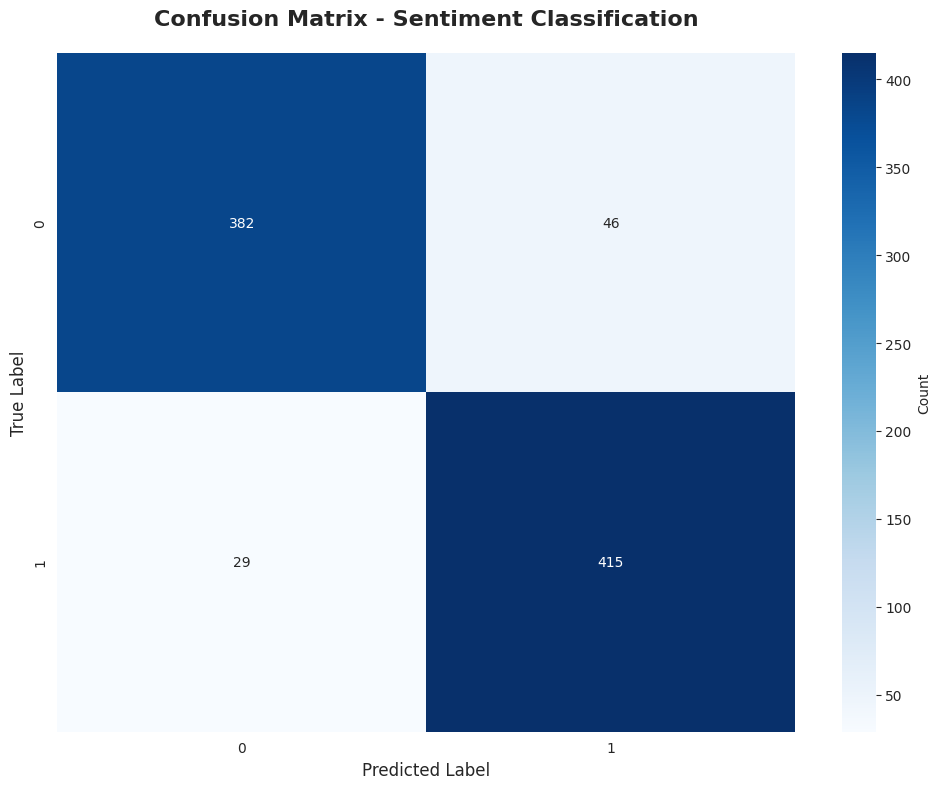

Confusion matrix saved to: visualizations/confusion_matrix.png

Confusion Matrix Analysis:
0: 382/428 correct (89.25%)
1: 415/444 correct (93.47%)


In [21]:
# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Convert label_names to strings
label_names = [str(label) for label in CONFIG['label_names']]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=[label.capitalize() for label in label_names],
    yticklabels=[label.capitalize() for label in label_names],
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix - Sentiment Classification', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(VIZ_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Confusion matrix saved to: {VIZ_DIR / 'confusion_matrix.png'}")

# Print confusion matrix statistics
print("\nConfusion Matrix Analysis:")
print("="*80)
for i, label in enumerate(label_names):
    total = cm[i].sum()
    correct = cm[i][i]
    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"{label.capitalize()}: {correct:,}/{total:,} correct ({accuracy:.2f}%)")

## 4.5 Misclassification Analysis

In [29]:
# Find misclassified examples
# Get the text from the original test dataset
test_texts = dataset['test']['sentence']
misclassified_indices = np.where(y_pred != y_true)[0]

# Convert label_names to strings
label_names = [str(label) for label in CONFIG['label_names']]

print("Misclassification Analysis")
print("="*80)
print(f"Total misclassifications: {len(misclassified_indices):,} out of {len(y_true):,}")
print(f"Error rate: {len(misclassified_indices) / len(y_true) * 100:.2f}%\n")

# Show some misclassified examples
print("Sample Misclassified Examples:")
print("-"*80)

num_examples = min(10, len(misclassified_indices))
sample_indices = np.random.choice(misclassified_indices, size=num_examples, replace=False)

for idx in sample_indices:
    print(f"\nText: {test_texts[idx]}")
    print(f"True Label: {label_names[y_true[idx]].capitalize()}")
    print(f"Predicted: {label_names[y_pred[idx]].capitalize()}")
    print("-"*80)

Misclassification Analysis
Total misclassifications: 75 out of 872
Error rate: 8.60%

Sample Misclassified Examples:
--------------------------------------------------------------------------------

Text: big fat liar is just futile silliness looking to tap into the kiddie sensibilities .
True Label: 0
Predicted: 1
--------------------------------------------------------------------------------

Text: its mysteries are transparently obvious , and it 's too slowly paced to be a thriller .
True Label: 1
Predicted: 0
--------------------------------------------------------------------------------

Text: although very much like the first movie based on j.k. rowling 's phenomenal fantasy best sellers , this second go-round possesses a quite pleasing , headlong thrust and a likably delinquent attitude .
True Label: 1
Predicted: 0
--------------------------------------------------------------------------------

Text: mark me down as a non-believer in werewolf films that are not serious and re